In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from natsort import natsorted

training_data_dir = Path('/hdd/yang/data/care2025/LiQA_training_data/')
venders = []
for subdir in training_data_dir.iterdir():
    if subdir.is_dir():
        venders.append(subdir.name)
print('Venders:', venders)

Venders: ['Vendor_A', 'Vendor_B2']


{'Vendor_A': {'S1': 54, 'S4': 37, 'S2': 24, 'S3': 11}, 'Vendor_B2': {'S2': 9, 'S4': 37, 'S3': 8, 'S1': 2}}


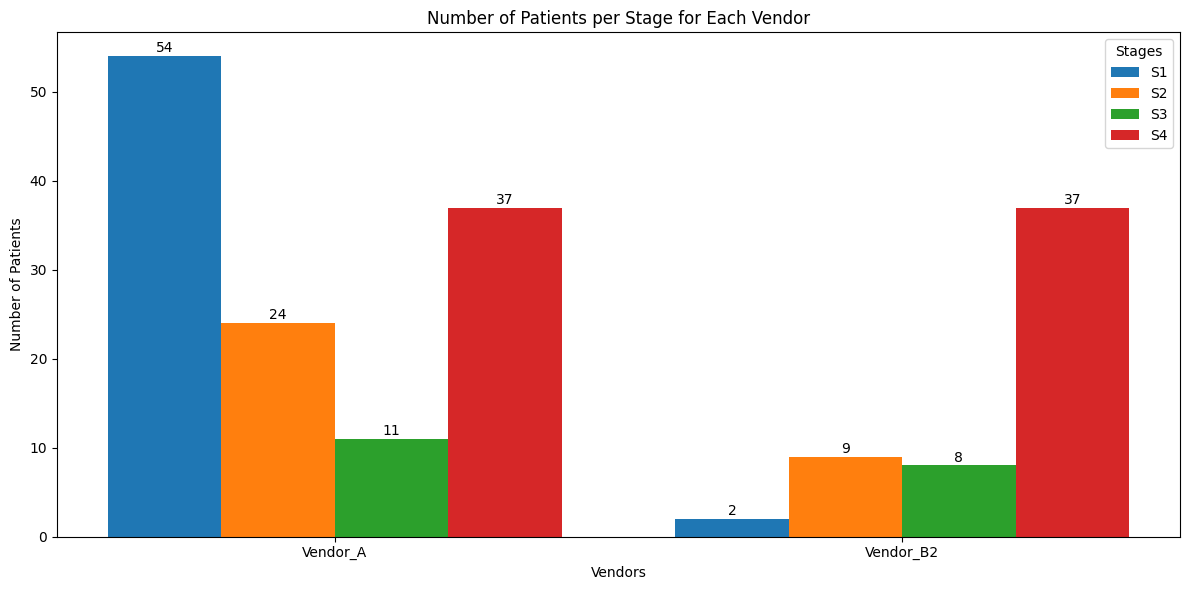

In [2]:
def set_empty_stage_as_zero(stage_dict):
    vendors = natsorted(list(stage_dict.keys()))
    stages = []
    for vendor in vendors:
        stages_per_vendor = natsorted(list(stage_dict[vendor].keys()))
        stages.extend(stages_per_vendor)
    stages = natsorted(set(stages))
    for vendor in vendors:
        for stage in stages:
            if stage not in stage_dict[vendor]:
                stage_dict[vendor][stage] = 0
    return stage_dict


def plot_stages_per_vendor(stage_dict):
    print(stage_dict)
    vendors = natsorted(list(stage_dict.keys()))
    stages = natsorted(list(set(stage for stages in stage_dict.values() for stage in stages.keys())))
    # plot bar chart and each stage as a different color
    num_vendors = len(vendors)
    num_stages = len(stages)
    bar_width = 0.8 / num_stages
    x = np.arange(num_vendors)
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, stage in enumerate(stages):
        stage_counts = [stage_dict[vendor].get(stage, 0) for vendor in vendors]
        ax.bar(x + i * bar_width, stage_counts, width=bar_width, label=stage)
        for j, count in enumerate([stage_dict[vendor].get(stage, 0) for vendor in vendors]):
            ax.text(x[j] + i * bar_width, count + 0.1, str(count), ha='center', va='bottom')
    ax.set_xlabel('Vendors')
    ax.set_ylabel('Number of Patients')
    ax.set_title('Number of Patients per Stage for Each Vendor')
    ax.set_xticks(x + bar_width * (num_stages - 1) / 2)
    ax.set_xticklabels(vendors)
    ax.legend(title='Stages')
    plt.tight_layout()

stage_dict = {}
for vender in venders:
    stage_dict_per_vendor = {}
    vender_dir = training_data_dir / vender
    for patient_dir in vender_dir.iterdir():
        if patient_dir.is_dir():
            stage = patient_dir.name.split('-')[-1]
            if stage not in stage_dict_per_vendor:
                stage_dict_per_vendor[stage] = 0
            else:
                stage_dict_per_vendor[stage] += 1
    stage_dict[vender] = stage_dict_per_vendor
stage_dict = set_empty_stage_as_zero(stage_dict)


plot_stages_per_vendor(stage_dict)

Identical modalities: ['DWI_800', 'GED1', 'GED2', 'GED3', 'GED4', 'T1', 'T2', 'T2WI', 'mask_GED4']
Modality matrix shape: {'Vendor_A': (9, 130), 'Vendor_B2': (9, 60)}
Yellos:True, Purple:False


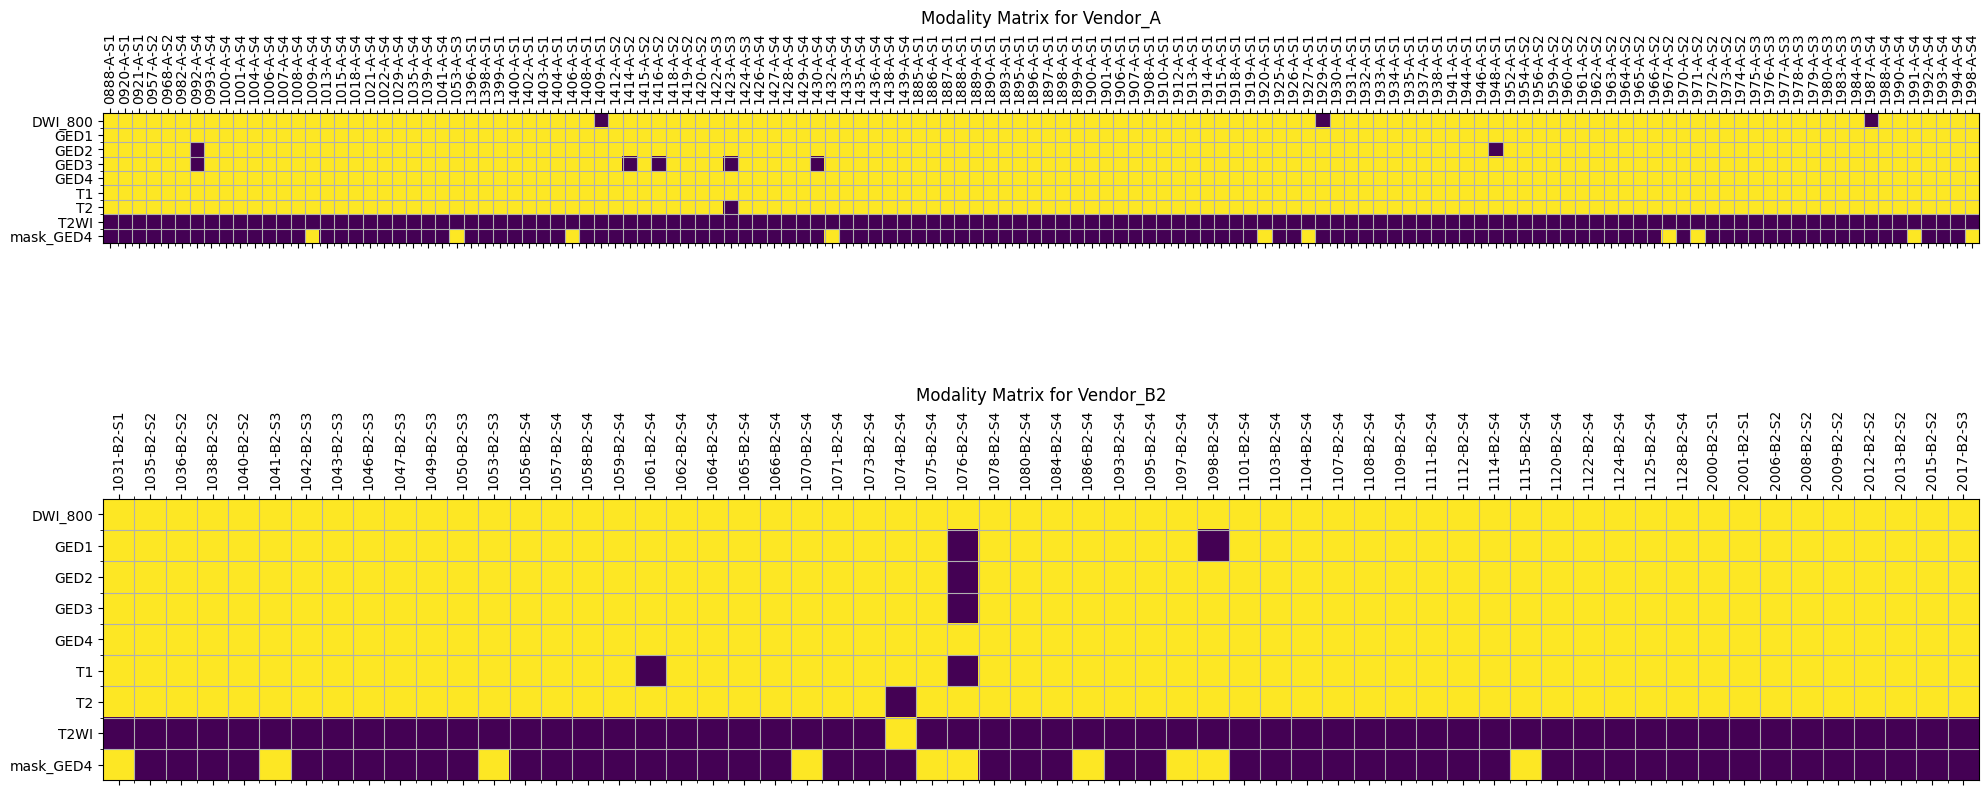

In [5]:
# plot modalities per vendor


def modality_type(modalities_dict):
    i_modality_list = []
    for vender, patients in modalities_dict.items():
        for patient, modalities in patients.items():
            i_modality_list.extend(modalities)
    return natsorted(list(set(i_modality_list)))

def generate_modality_matrix(vender_dict, identical_modality_list):
    """
    2 d matrix with patient as column and modality as row
    """
    modality_matrix = np.zeros((len(identical_modality_list), len(vender_dict.keys())))
    for i, modality in enumerate(identical_modality_list):
        for j, (patient, modalities) in enumerate(vender_dict.items()):
            if modality in modalities:
                modality_matrix[i, j] = 1
    return modality_matrix

def plot_modality_matrix(modality_matrix_dict, identical_modality_list, modalities_dict):
    fig, axes = plt.subplots(nrows=len(modality_matrix_dict), figsize=(20, 10))

    for ax, (vender, matrix) in zip(axes, modality_matrix_dict.items()):
        x_labels = list(modalities_dict[vender].keys())
        # set grid for the matrix
        cax = ax.matshow(matrix, cmap='viridis')
        ax.set_xticks(np.arange(matrix.shape[1]))
        ax.set_xticklabels(x_labels, rotation=90, ha='center')
        ax.set_yticks(np.arange(matrix.shape[0]))
        ax.set_yticklabels(identical_modality_list)
        ax.set_title(f'Modality Matrix for {vender}')
        ax.set_xticks([x - 0.5 for x in ax.get_xticks()][1:], minor=True)
        ax.set_yticks([y - 0.5 for y in ax.get_yticks()][1:], minor=True)
        ax.grid(which='minor')
        #plt.colorbar(cax, ax=ax)
    plt.tight_layout()


modalities_dict = {}
for vender in venders:
    vender_dict = {}
    vender_dir = training_data_dir / vender
    for patient_dir in vender_dir.iterdir():
        if patient_dir.is_dir():
            vender_dict[patient_dir.name] = []
            for image_file in patient_dir.glob('*.nii.gz'):
                modality = image_file.name.split('.')[0]
                if modality not in vender_dict[patient_dir.name]:
                    vender_dict[patient_dir.name].append(modality)
    modalities_dict[vender] = vender_dict
#print(modalities_dict)
# sorting dict based on patient id
for vender, patients in modalities_dict.items():
    modalities_dict[vender] = dict(sorted(patients.items(), key=lambda item: item[0]))
#print(modalities_dict)
modality_list = modality_type(modalities_dict)
print('Identical modalities:', modality_list)

modality_matrix_dict = {}
for vender, patients in modalities_dict.items():
    modality_matrix = generate_modality_matrix(patients, modality_list)
    modality_matrix_dict[vender] = modality_matrix
print('Modality matrix shape:', {vender: matrix.shape for vender, matrix in modality_matrix_dict.items()})

print('Yellos:True, Purple:False')

plot_modality_matrix(modality_matrix_dict, modality_list, modalities_dict)


For Vendor A, 10 annotations are available, S1 : 3, S2 : 2, S3 : 1, S4 : 4

For Vendor B, 10 annotations are available, S1 : 1, S2 : 0, S3 : 2, S4 : 7

In [16]:
import nibabel as nib
sample_data = '/hdd/yang/data/care2025/LiQA_training_data/Vendor_A/0888-A-S1/DWI_800.nii.gz'
img = nib.load(sample_data)
print('Data type: ', img.get_data_dtype())
print('Sample data shape (xyz): ', img.shape)
print('Units: ', img.header.get_xyzt_units())
print('Voxel size (xyz): ', img.header.get_zooms())


Data type:  float32
Sample data shape (xyz):  (256, 208, 30)
Units:  ('mm', 'unknown')
Voxel size (xyz):  (np.float32(1.5625), np.float32(1.5625), np.float32(6.6))
